# Focal Adhesion Analysis Notebook

This notebook shows an example of the focal adhesion analysis workflow used in the paper:

RhoA mediates stress fiber strain site recognition by the LIM protein testin<br>
Sala S, Oakes PW<br>
2021

https://www.biorxiv.org/content/10.1101/2021.01.21.427693v1

See Supplemental Figure 4

In [1]:
import skimage.io as io                                                 # For reading the image
import os
import cv2                                                              # computer vision toolbox
import matplotlib.pyplot as plt                                         # For displaying the image and plots
from skimage import filters, measure, morphology                        # for filtering
from skimage.morphology import *                                        # morphological filters
from skimage.feature import peak_local_max                              # function to find local maxima
from skimage.measure import label                                       # For labeling regions in thresholded images
from skimage.measure import regionprops                                 # For calculating properties of labeled regions
from skimage.segmentation import clear_border                           # Removes pixels from the borders of thresholded images
from skimage.color import label2rgb                                     # Pretty display labeled images
from skimage.morphology import remove_small_objects, remove_small_holes # Clean up small objects or holes in our image
import pandas as pd                                                     # For creating our dataframe 
import numpy as np                                                      # General mathematical functions
import scipy as sci
from scipy import optimize, ndimage                                     # for curve fitting
from scipy.ndimage import morphology                                    # morphological operations
from image_correction_tools import *                                    # image corrections
import scikit_posthocs as sp                                            # statistical analysis
import glob as glob                                                     # for finding files
import shutil                                                           # for moving files

# Make the figures that we display interactive
%matplotlib notebook  

In [2]:
# Function to make a cell mask
def cellmask_threshold(im):
    
    # Find the unique intensity values in the image
    intensity_values = np.unique(im.ravel())
    
    # reduce list of intensity values down to something manageable to speed up computation
    slice_width = np.round(len(intensity_values)/300).astype('int')
    intensity_values = intensity_values[::slice_width]
    
    
    # Find the mean intensity value of the image
    intensity_mean = np.mean(im)
    
    # create a zero matrix to hold our difference values
    intensity_difference = np.zeros_like(intensity_values).astype('float')
    
    # for loop to compare the difference between the intensity sum of pixels above a threshold 
    # and the average image intensity of an identical number of pixels
    
    for i,intensity in enumerate(intensity_values):
        
        # make a mask of pixels about a given intensity
        mask = im > intensity
        
        # take the difference between the sum of thresholded pixels and the average value of those pixels
        intensity_difference[i] = np.sum(mask * im) - intensity_mean*np.sum(mask)
        
    # find the maximum value of the intensity_difference and set it equal to the threshold
    max_intensity = np.argwhere(intensity_difference == np.max(intensity_difference))
    threshold = intensity_values[max_intensity[0][0]]
    
    # make a mask at this threshold
    mask = im > threshold
    
    # get rid of small objects
    mask = remove_small_objects(mask, 250)
    
    # fill any holes in the mask
    mask = morphology.binary_fill_holes(mask)
    
    return mask

# Function to calculate the intensity of a protein in and around focal adhesions
def FA_analysis_singlecell(Tes, FA, basename):
    
    # flatfield correct the FA image
    FA_FF_corrected = flat_field_correct_image(FA,'Prime',63,'561short')

    # filter the FA image with a LoG filter
    im_LoG = cv2.filter2D(FA_FF_corrected.astype('float'), cv2.CV_32F, LoG)
    
    # threshold the filtered image using 3 times the std deviation of the image
    thresh = np.std(im_LoG.ravel()) * 3
    im_LoG_mask = im_LoG > thresh

    # define the pixel size
    um_per_pix = 11 / 63.
    # define the lower threshold size of regions
    sm_thresh = 1/um_per_pix/um_per_pix
    
    # Make masks of the FA image and remove small objects and holes
    mask_FA = remove_small_objects(im_LoG_mask,sm_thresh)
    mask_FA = remove_small_holes(mask_FA)

    # Make a mask of the entire cell based off the testin image
    cell_mask = cellmask_threshold(Tes)
    
    # label the FA mask regions
    labeled_FA = label(mask_FA*cell_mask)
    # get region properties of FAs
    props_FA = regionprops(labeled_FA, intensity_image = FA)

    # create empty lists for FA analysis
    FA_area, Pax_intensity, Tes_intensity = [], [], []

    # loop through adhesions
    for adhesions in props_FA:
        # get the adhesion area
        FA_area.append(adhesions.area)
        # get the average intensity of the adhesion
        Pax_intensity.append(adhesions.mean_intensity)
        #get the intensity of the Testin signal in adhesion
        Tes_all_adhesion_intensities = []
        for coordinates in adhesions.coords: 
            Tes_all_adhesion_intensities.append(Tes[coordinates[0], coordinates[1]])
        Tes_intensity.append(np.mean(Tes_all_adhesion_intensities))
        

    # create empty lists for the cytoplasmic area surrounding adhesions
    Pax_donut_intensity, Tes_donut_intensity = [], []

    # loop through adhesions to check surrounding cytoplasmic region
    for labeled_adhesion in np.arange(1,np.max(labeled_FA)+1):
        # make a mask of the adhesion
        new_mask_FA = np.zeros(labeled_FA.shape)
        new_mask_FA[labeled_FA == labeled_adhesion] = True
        # dilate the mask with a square structuring element
        dilate_new_mask_FA = binary_dilation(new_mask_FA, selem=np.ones((10, 10)))
        # multiply by inverse of adhesion mask to create the donut
        donut_mask_FA = dilate_new_mask_FA * np.invert(mask_FA)
        # multiply by cell mask to remove pixels in donut outside of the cell
        donut_mask_FA = donut_mask_FA * cell_mask 
        # get properties of that region
        labeled_donut_FA = label(donut_mask_FA)
        labeled_donut_FA[labeled_donut_FA>1] = 0
        props_donut_FA = regionprops(labeled_donut_FA, intensity_image = FA)
    
        # loop through the donut (should be a single region but sometimes you get two depending on the cellmask)
        for donuts in props_donut_FA:
            # get FA intensity in donut
            Pax_donut_intensity.append(donuts.mean_intensity)
            # get the testin intensity in donut
            list_all_donut_intensities_Tes = []
            for coordins in donuts.coords:
                list_all_donut_intensities_Tes.append((Tes[coordins[0], coordins[1]]))
            Tes_donut_intensity.append(np.mean(list_all_donut_intensities_Tes))
            
    # create empty lists to hold the ratio of the FA to the surrounding donut for testin and paxillin
    Pax_ratio, Tes_ratio = [], []

    # calculate the ratio of the FA signal in FA to surrounding cytoplasm
    for adhesion_intensity, donut_intensity in zip(Pax_intensity, Pax_donut_intensity): 
        Pax_ratio.append(adhesion_intensity/donut_intensity)
    
    # calculate the ratio of the testin signal in FA to surrounding cytoplasm
    for adhesion_intensity, donut_intensity in zip(Tes_intensity, Tes_donut_intensity): 
        Tes_ratio.append(adhesion_intensity/donut_intensity)
    
    # make images of FA and testin ratios in FAs
    Pax_ratio_image = np.zeros(labeled_FA.shape)
    Tes_ratio_image = np.zeros(labeled_FA.shape)
    for i, val in enumerate(Pax_ratio):
        Pax_ratio_image[labeled_FA == (i+1)] = val
        Tes_ratio_image[labeled_FA == (i+1)] = Tes_ratio[i]
        
    # Plot the original FA intensity image and mask
    FA_fig, FA_axis = plt.subplots(nrows = 2, ncols = 3)

    FA_axis[0,0].imshow(FA, cmap = 'gray')
    FA_axis[0,0].set_title(basename + ' FA intensity')
    FA_axis[0,1].imshow(mask_FA, cmap = 'gray')
    FA_axis[0,1].set_title('FA mask')
    FA_axis[0,2].imshow(Pax_ratio_image, cmap='magma', vmin=0, vmax = 2.5)
    FA_axis[0,2].set_title('Pax FA/cytoplasm ratio')
    FA_axis[1,0].imshow(Tes, cmap = 'gray')
    FA_axis[1,0].set_title('Tes intensity')
    FA_axis[1,1].imshow(cell_mask, cmap = 'Greys_r')
    FA_axis[1,1].set_title('cell mask')
    FA_axis[1,2].imshow(Tes_ratio_image, cmap='magma', vmin=0, vmax = 2.5)
    FA_axis[1,2].set_title('Tes FA/cytoplasm ratio')
    for ax in FA_axis.ravel():
        ax.axis('off')

    FA_fig.show()
    # save the figure
    FA_fig.savefig(basename + ' FA mask.png')

    # make a dictionary of values
    Adhesion_dict = {
        'Adhesion area': FA_area,
        'Adhesion intensities Pax': Pax_intensity,
        'Donut intensities Pax': Pax_donut_intensity,
        'Pax intensity ratio': Pax_ratio,
        'Adhesion intensities Tes': Tes_intensity,
        'Donut intensities Tes': Tes_donut_intensity,
        'Tes intensity ratio': Tes_ratio}

    # convert the dictionary to a dataframe
    Adhesion_dataframe = pd.DataFrame(Adhesion_dict)
    
    # save the data to a csv
    Adhesion_dataframe.to_csv(basename + ' cell summary.csv')

    return FA_area, Pax_intensity, Pax_donut_intensity, Pax_ratio, Tes_intensity, Tes_donut_intensity, Tes_ratio

Number of cells: 5 

['FA_example/Y111E/1_XY1595887197_Z0_T0_C0.tif', 'FA_example/Y111E/2_XY1595887329_Z0_T0_C0.tif', 'FA_example/Y111E/3_XY1595887458_Z0_T0_C0.tif', 'FA_example/Y111E/4_XY1595887593_Z0_T0_C0.tif', 'FA_example/Y111E/5_XY1595887635_Z0_T0_C0.tif']


<IPython.core.display.Javascript object>


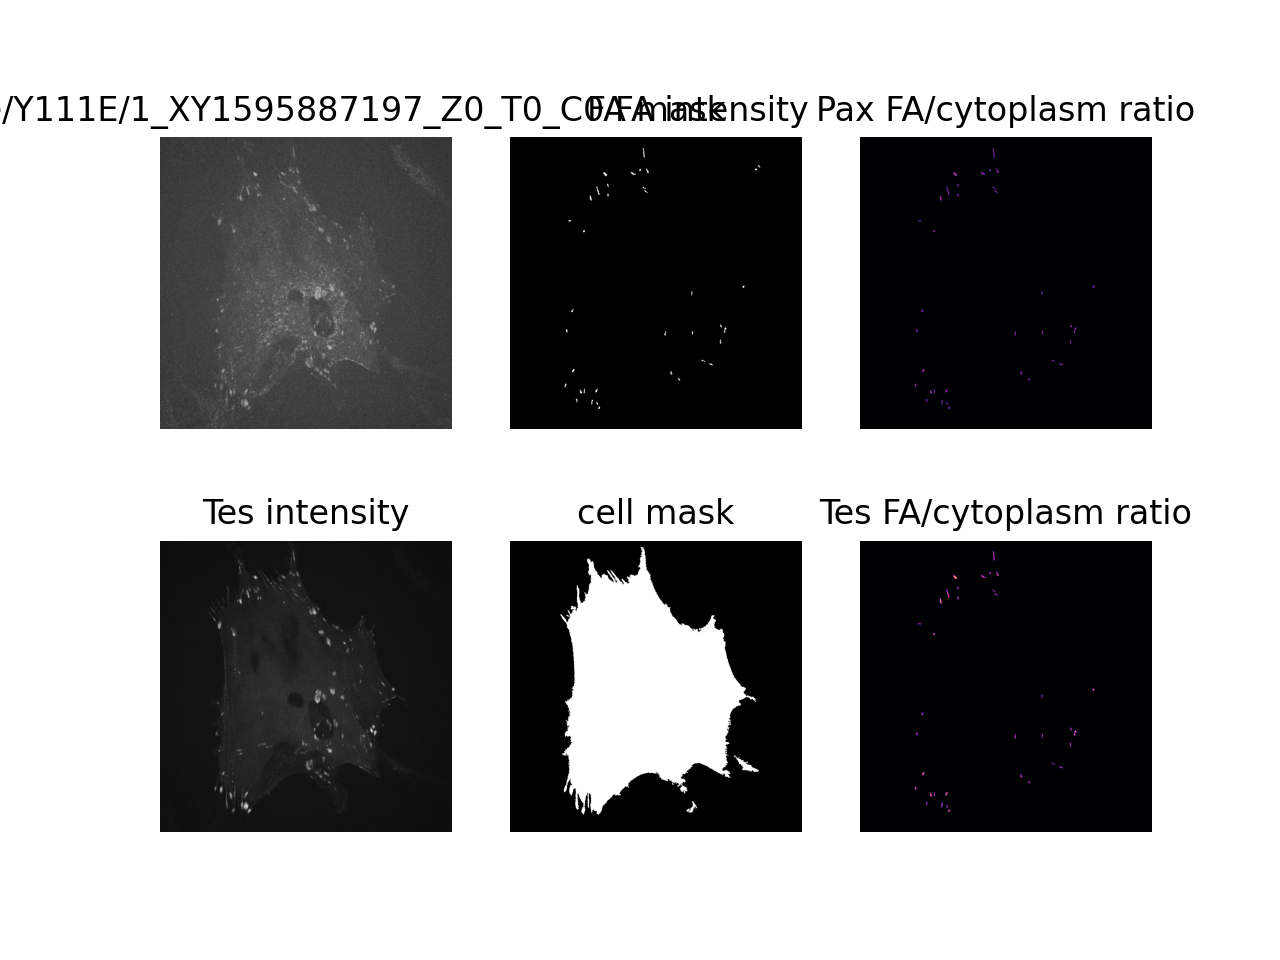

<IPython.core.display.Javascript object>


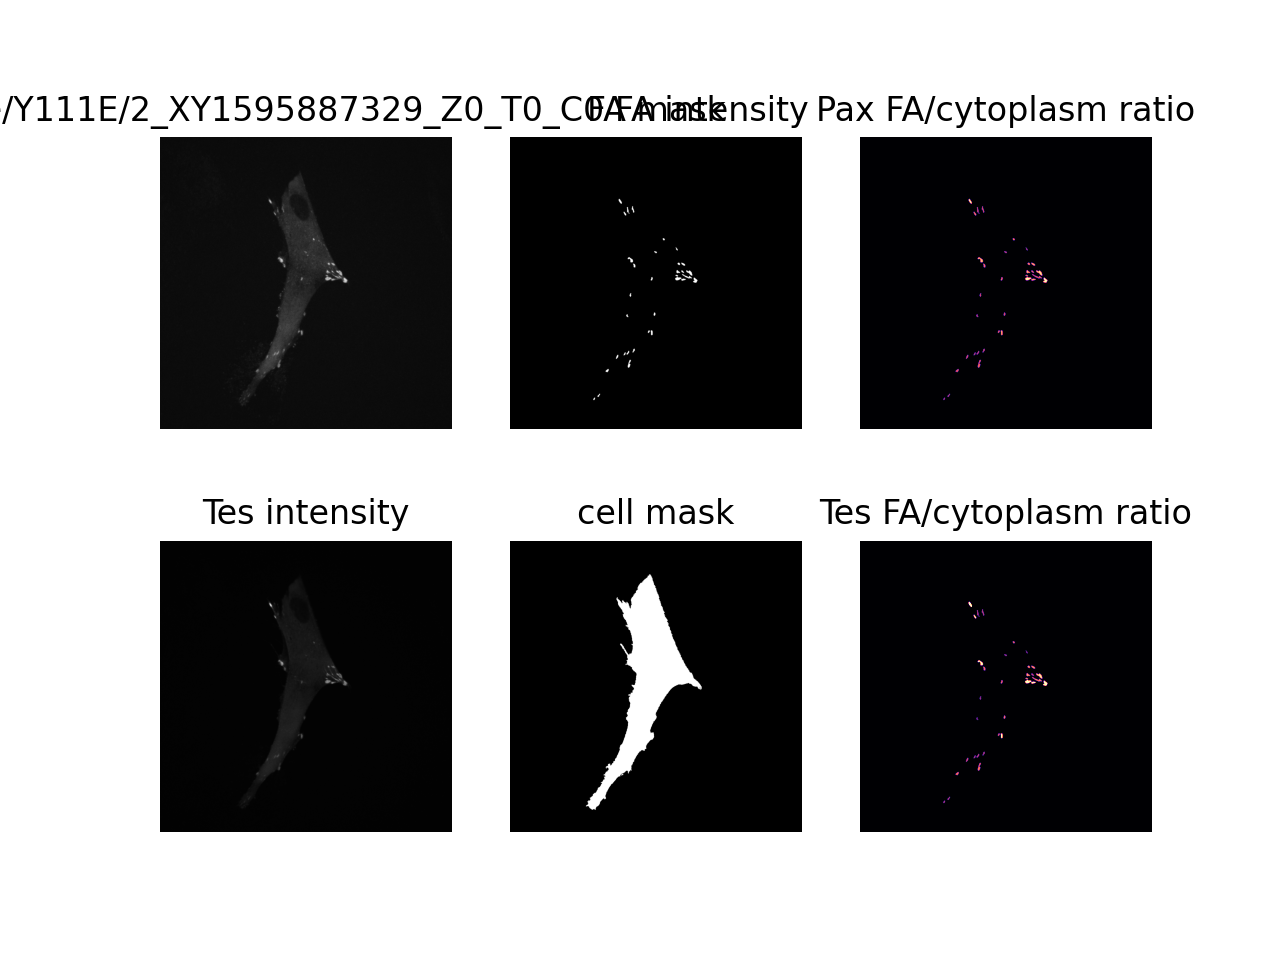

<IPython.core.display.Javascript object>


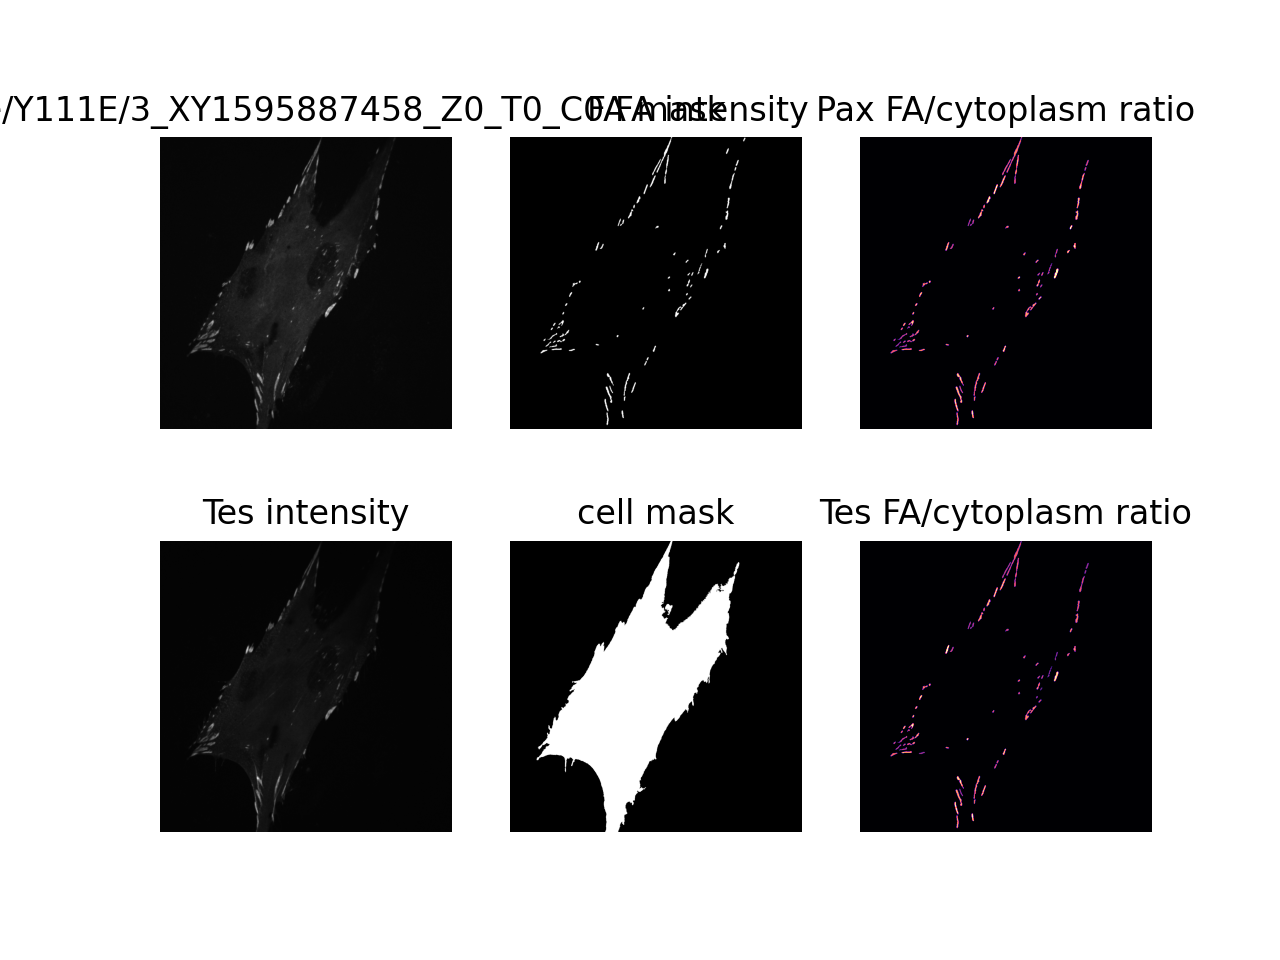

<IPython.core.display.Javascript object>


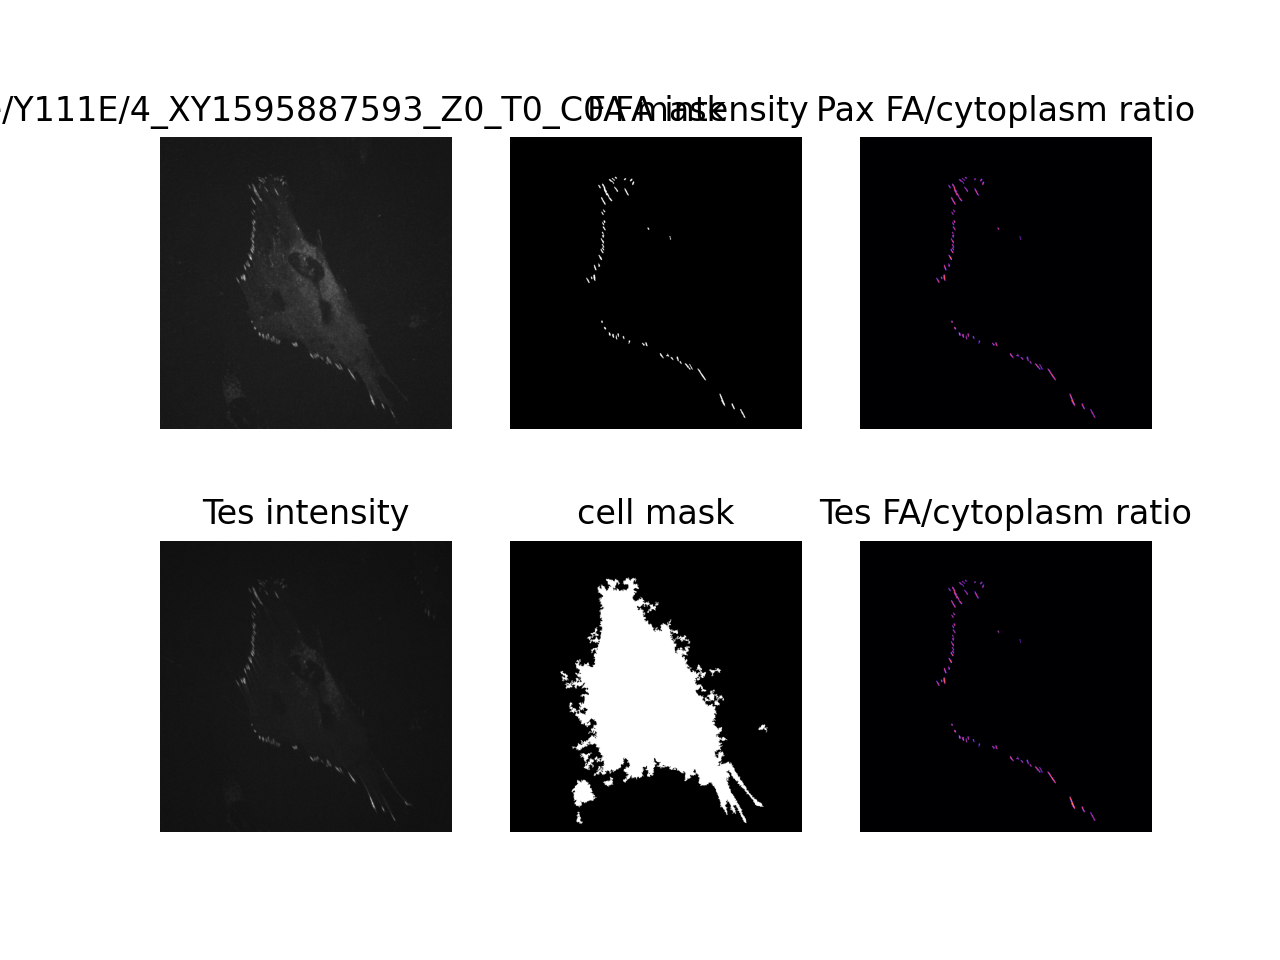

<IPython.core.display.Javascript object>


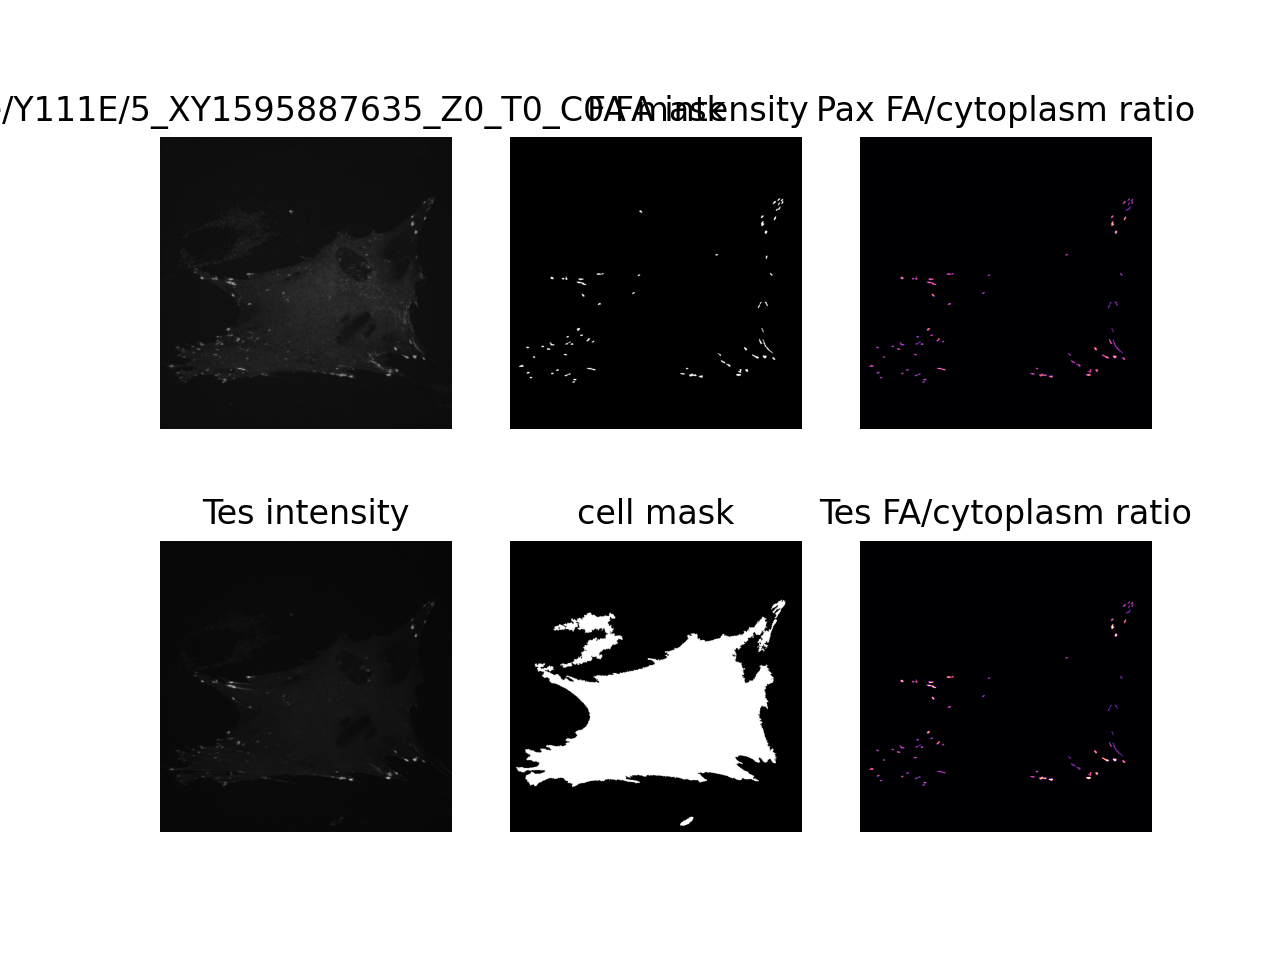

In [3]:
Data_list = sorted(glob.glob('FA_example/Y111E/*C0.tif'))
print('Number of cells:', len(Data_list), '\n')
print(Data_list)

# create empty lists for all our data
All_FA_area, All_Pax_intensity, All_Pax_donut_intensity, All_Pax_ratio = [], [], [], []
All_Tes_intensity, All_Tes_donut_intensity, All_Tes_ratio = [], [], []
filename_list, Pax_mean, Tes_mean = [], [], []

# Make Laplace of Gaussian (LoG) filter
# Gaussian kernel
gaussian_kernel = cv2.getGaussianKernel(15, 2)
# Multiply the vector by it's transpose to make a matrix
gaussian_kernel = gaussian_kernel * gaussian_kernel.T
# Create a Laplacian
Laplace = np.array([[0, -1, 0],[-1, 4, -1],[0, -1, 0]])
# Convolve to make a 2D Laplace of Gaussian Filter
LoG = cv2.filter2D(gaussian_kernel, -1, Laplace)
    
# for loop to analyze every image
for file in Data_list:
    # read in image
    Testin_construct = io.imread(file)
    # assign the channels to testin or FA
    if Testin_construct.shape[0] == 2:
        FA_marker = Testin_construct[1]
        Testin_construct = Testin_construct[0]
    else: 
        FA_marker = Testin_construct[:,:,1]
        Testin_construct = Testin_construct[:,:,0]
        
    # Perform the FA analysis
    FA_area, Pax_intensity, Pax_donut_intensity, Pax_ratio, Tes_intensity, Tes_donut_intensity, Tes_ratio = FA_analysis_singlecell(Testin_construct, FA_marker, file[:-4])

    # add the data to our lists
    All_FA_area.append(FA_area)
    All_Pax_intensity.append(Pax_intensity)
    All_Pax_donut_intensity.append(Pax_donut_intensity)
    All_Pax_ratio.append(Pax_ratio)
    All_Tes_intensity.append(Tes_intensity)
    All_Tes_donut_intensity.append(Tes_donut_intensity)
    All_Tes_ratio.append(Tes_ratio)
    Pax_mean.append(np.mean(Pax_ratio))
    Tes_mean.append(np.mean(Tes_ratio))
    filename_list.append(file)

# Make a dictionary with our lists
All_adhesion_dict = {
        'Adhesion area': All_FA_area,
        'Adhesion intensities Pax': All_Pax_intensity,
        'Donut intensities Pax': All_Pax_donut_intensity,
        'Pax intensity ratio': All_Pax_ratio,
        'Adhesion intensities Tes': All_Tes_intensity,
        'Donut intensities Tes': All_Tes_donut_intensity,
        'Tes intensity ratio': All_Tes_ratio,
        'Pax mean intensity': Pax_mean,
        'Tes mean intensity': Tes_mean}

# convert the dictionary to a dataframe
All_adhesion_dataframe = pd.DataFrame(All_adhesion_dict)

# save the dataframe to a csv file
All_adhesion_dataframe.to_csv('Construct summary Y111E.csv')